`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

In [2]:
xrootdstr1 = 'root://cmseos.fnal.gov//'
xrootdstr2 = 'root://cmsxrootd.fnal.gov//'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'

In [3]:
qcdfilename = 'QCD.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr1 + s.strip() for s in f.readlines()]

In [5]:
jetdatafilename = 'JetHT_Data.txt'
with open(jetdatafilename) as f:
    #jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines() if "/store/data/Run2017" in s]
    jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines()[::3]] # Every third datafile

In [6]:
#print(jetdatafiles[2]) # Test to see if correct files are collected

In [7]:
from distributed import Client
client = Client('coffea-dask.fnal.gov:8786')

In [8]:
prng = RandomState(1234567890)

In [9]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, htCut=1100., minMSD=105., maxMSD=210., tau32Cut=0.7, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019, UseLookUpTables=False,
                lu = None):
        
        #self.prng = RandomState(1234567890)
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        self.UseLookUpTables = UseLookUpTables
        self.lu = lu # Look Up Tables
        
        self.ttagcats = ["At","at", "0t", "1t", "2t"] #anti-tag+probe, anti-tag, 0, 1, >=2 ttags
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 5000)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -4, 4)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -3.14, 3.14)
        jety_axis = hist.Bin("jety", r"Jet $y$", 50, -3, 3)
        jetdy_axis = hist.Bin("jetdy", r"Jet $\Delta y$", 50, 0, 3)
        jetp_axis = hist.Bin("jetp", r"Jet $p$ [GeV]", 50, 0, 5000)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -3.14, 3.14)

        self._accumulator = processor.dict_accumulator({
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'jeteta':    hist.Hist("Counts", dataset_axis, cats_axis, jeteta_axis),
            'probept':   hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'probep':    hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),

            'jetphi':    hist.Hist("Counts", dataset_axis, cats_axis, jetphi_axis),
            'jety':      hist.Hist("Counts", dataset_axis, cats_axis, jety_axis),
            'jetdy':     hist.Hist("Counts", dataset_axis, cats_axis, jetdy_axis),
            
            'subjetmass':   hist.Hist("Counts", dataset_axis, cats_axis, subjetmass_axis),
            'subjetpt':     hist.Hist("Counts", dataset_axis, cats_axis, subjetpt_axis),
            'subjeteta':    hist.Hist("Counts", dataset_axis, cats_axis, subjeteta_axis),
            'subjetphi':    hist.Hist("Counts", dataset_axis, cats_axis, subjetphi_axis),
            
            'numerator': hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'denominator': hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            
        })

            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        
        #dataset = events.metadata['dataset']
        dataset = df['dataset']
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB'],
            deepTag_TvsQCD=df['FatJet_deepTag_TvsQCD'],
            deepTagMD_TvsQCD=df['FatJet_deepTagMD_TvsQCD']
            )
        # ---- Define Jets ---- #
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nSubJet'],
            pt=df['Jet_pt'],
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass']
            )
        
        # ---- Get event weights from dataset ---- #
        if 'JetHT' in dataset: # If data is used...
            evtweights = np.ones(FatJets.size) # set all "data weights" to one
        else: # if Monte Carlo dataset is used...
            evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        
        # ---- Show all events ---- #
        output['cutflow']['all events'] += FatJets.size        
        
        # ---- Apply HT Cut ---- #
        hT = Jets.pt.sum()
        passhT = (hT > self.htCut)
        evtweights = evtweights[passhT]
        FatJets = FatJets[passhT]
        
        # ---- FatJets Info ---- #
        oneFatJet = (FatJets.counts >= 1) # at least one fat jet
        FatJets = FatJets[oneFatJet]
        evtweights = evtweights[oneFatJet]
        output['cutflow']['one FatJets'] += oneFatJet.sum()
        
        twoFatJets = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJets]
        evtweights = evtweights[twoFatJets]
        output['cutflow']['two FatJets'] += twoFatJets.sum()

        jet_id = (FatJets.jetId > 0)
        
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5) # eta cut here
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()

        twoFatJetsKin = (FatJets.counts >= 2) # Whats the difference from twoFatJets ?
        FatJets = FatJets[twoFatJetsKin]
        evtweights = evtweights[twoFatJetsKin]
        output['cutflow']['two FatJets and jet kin'] += twoFatJetsKin.sum()
        
        FatJets = FatJets[:,0:2]
        
        # ---- Randomly Select AK8 Jet as TTbar Candidate --- #

        index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), prng.randint(2, size=len(FatJets)))
        jet0 = FatJets[index]
        jet1 = FatJets[1 - index]
        
        #print("index size = ", index.size)
        #print(index.tolist())
        #print()
        
        ttbarcands = jet0.cross(jet1) #FatJets[:,0:2].distincts()
        
        # ---- Look for more than one TTbar candidate and re-broadcast releveant arrays  ---- #
        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]
         
        # ---- Apply Delta Phi Cut ---- #
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut] 
        
        
        # ---- Get Analysis Categories ---- # 
        # ---- They are (central, forward)   cross   (0b,1b,>=2b) ---- #
        cen = np.abs(ttbarcands.i0.p4.rapidity - ttbarcands.i1.p4.rapidity) < 1.0
        fwd = (~cen)
        tau32_i0 = np.where(ttbarcands.i0.tau2>0,ttbarcands.i0.tau3/ttbarcands.i0.tau2, 0 )
        tau32_i1 = np.where(ttbarcands.i1.tau2>0,ttbarcands.i1.tau3/ttbarcands.i1.tau2, 0 )
        taucut_i0 = tau32_i0 < self.tau32Cut
        taucut_i1 = tau32_i1 < self.tau32Cut
        mcut_i0 = (self.minMSD < ttbarcands.i0.msoftdrop) & (ttbarcands.i0.msoftdrop < self.maxMSD) 
        mcut_i1 = (self.minMSD < ttbarcands.i1.msoftdrop) & (ttbarcands.i1.msoftdrop < self.maxMSD) 

        ttag_i0 = (taucut_i0) & (mcut_i0)
        ttag_i1 = (taucut_i1) & (mcut_i1)
        antitag = (~taucut_i0) & (mcut_i0) #Probe will always be ttbarcands.i1
        
        ttag0 = (~ttag_i0) & (~ttag_i1)
        ttag1 = ttag_i0 ^ ttag_i1
        ttag2 = ttag_i0 & ttag_i1

        btag_i0 = (ttbarcands.i0.btagDeepB > self.bdisc)
        btag_i1 = (ttbarcands.i1.btagDeepB > self.bdisc)
        
        btag0 = (~btag_i0) & (~btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        antitag_probe = np.logical_and(antitag, ttag_i1) #Found an antitag and ttagged probe pair for mistag rate
        
        regs = [cen,fwd]
        btags = [btag0,btag1,btag2]
        ttags = [antitag_probe,antitag,ttag0,ttag1,ttag2]
        cats = [ (t&b&y).flatten() for t,b,y in itertools.product( ttags, btags, regs) ]
        labels_and_categories = dict(zip( self.anacats, cats ))
        
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        jetpt = ttbarcands.i1.pt.flatten()
        jeteta = ttbarcands.i1.eta.flatten()
        jetphi = ttbarcands.i1.phi.flatten()
        jety = ttbarcands.i1.p4.rapidity.flatten()
        jetdy = np.abs(ttbarcands.i0.p4.rapidity.flatten() - ttbarcands.i1.p4.rapidity.flatten())
        
        #print("jetpt both = ", ttbarcands.pt.flatten())
        #print("jetpt control = ", ttbarcands.i0.pt.flatten())
        #print("jetpt probe = ", ttbarcands.i1.pt.flatten())
        #print()
        
        weights = evtweights.flatten()
        #weights[weights < 0] = 0
        
        # ---- Define the SumW2 for MC Datasets ---- #
        output['cutflow']['sumw'] += np.sum(weights)
        output['cutflow']['sumw2'] += np.sum(weights**2)
        # ---- Define Momentum p of probe jet as the Mistag Rate variable; M(p) ---- #
        # ---- Transverse Momentum pT can also be used instead; M(pT) ---- #
        pT = ttbarcands.i1.pt.flatten()
        eta = ttbarcands.i1.eta.flatten()
        pz = np.sinh(eta)*pT
        p = np.absolute(np.sqrt(pT**2 + pz**2))
        
        # ---- Define the Numerator and Denominator for Mistag Rate ---- #
        numerator = np.where(antitag_probe, pT, -9999) # If no antitag and tagged probe, move event to useless bin
        denominator = np.where(antitag, pT, -9999) # If no antitag, move event to useless bin
        
        df = pd.DataFrame({"transverse momentum":pT}) # Used for finding values in LookUp Tables
        
        for ilabel,icat in labels_and_categories.items():
            ### ------------------------------------ Mistag Scaling ------------------------------------ ###
            if self.UseLookUpTables == True:
                file_df = self.lu['at' + str(ilabel[2:])] # get mistag (lookup) filename for 'at'
                bin_widths = file_df['pT'].values # collect bins as written in .csv file
                mtr = file_df['M(pT)'].values # collect mistag rate as function of p as written in file
                wgts = mtr # Define weights based on mistag rates
                BinKeys = np.arange(bin_widths.size) # Use as label for BinNumber column in the new dataframe
                print('bin_widths = \n', bin_widths)
                print('\n pT = \n', pT)
                print('\n BinKeys = \n', BinKeys)
# for M('p')                Bins = np.arange(bin_widths.size+1)*100. # Temporary definition of bins as floats
# for M('p')               P = np.where(p>5000., 5000., p) # Avoids momentum larger than the allowed bin size; caps the momentum
                Bins = pd.interval_range(start=0, periods=50, freq=100, closed='left') # Recreate the momentum bins from file_df as something readable for pd.cut()
                #PT = np.where(pT>2000., 2000., pT)
                print('\n bin_widths -> Readable Bins = \n', Bins)
        
                df['BinWidth'] = pd.cut(pT, bins=Bins) # new dataframe column
                df['BinNumber'] = pd.cut(pT, bins=Bins).map(dict(zip(Bins,BinKeys))) # new dataframe column
                
                BinNumber = df['BinNumber'].values # Collect the Bin Numbers into a numpy array
                print('\n Bin Number = \n', BinNumber)
                BinNumber = BinNumber.astype('int64') # Insures the bin numbers are integers
                WeightMatching = wgts[BinNumber] # Match 'wgts' with corresponding p bin using the bin number
                Weights = WeightMatching # Include 'wgts' with the previously defined 'weights'
                print()
                
                df['Weights'] = Weights
                print(str(ilabel[2:]) + '\n*************************************************\n')
                with pd.option_context('display.max_rows', None, 'display.max_columns', None):
                    print(df, '\n')
            else:
                Weights = np.ones(weights.size) # No mistag rates, no change to weights
            ###---------------------------------------------------------------------------------------------###
            output['cutflow'][ilabel] += np.sum(icat)
          
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=Weights[icat])
            output['jetpt'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=jetpt[icat],
                                weight=Weights[icat])
            output['probept'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=pT[icat],
                                weight=Weights[icat])
            output['jeteta'].fill(dataset=dataset, anacat=ilabel, 
                                jeteta=jeteta[icat],
                                weight=Weights[icat])
            output['jetphi'].fill(dataset=dataset, anacat=ilabel, 
                                jetphi=jetphi[icat],
                                weight=Weights[icat])
            output['jety'].fill(dataset=dataset, anacat=ilabel, 
                                jety=jety[icat],
                                weight=Weights[icat])
            output['jetdy'].fill(dataset=dataset, anacat=ilabel, 
                                jetdy=jetdy[icat],
                                weight=Weights[icat])
            output['numerator'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=numerator[icat],
                                weight=Weights[icat])
            output['denominator'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=denominator[icat],
                                weight=Weights[icat])
            output['probep'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=p[icat],
                                weight=Weights[icat])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [10]:
tstart = time.time()

filesets = {
    'QCD':qcdfiles,
    #'TTbar':ttbarfiles,
    #'JetHT':jetdatafiles
}

outputs_unweighted = {}

for name,files in filesets.items(): 

    print(name)
    output = processor.run_uproot_job({name:files},
                                      treename='Events',
                                      processor_instance=TTbarResProcessor(UseLookUpTables=False),
                                      executor=processor.dask_executor,
                                      #executor=processor.iterative_executor,
                                      #executor=processor.futures_executor,
                                      executor_args={
                                          'client': client, 
                                          'nano':False, 
                                          'flatten':True, 
                                          'skipbadfiles':False,
                                          'workers': 2},
                                      chunksize=100000, maxchunks=100
                                     )

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    print(output)
    util.save(output, 'TTbarResCoffea_' + name + '_unweighted_output_100000chunksize_100chunks.coffea')

QCD
['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']
{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7faff45f3950>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fb00c3658d0>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fb00c365910>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7faff59e1b90>, 'probept': <Hist (dataset,anacat,jetpt) instance at 0x7faff5a20150>, 'probep': <Hist (dataset,anacat,jetp) instance at 0x7faff5a20190>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7faff5a20090>, 'jety': <Hist (dataset,anacat,jety) instance at 0x7faff456fe10>, 'jetdy': <Hist (dataset,anacat,jetdy) instance at 0x7faff456ff90>, 'subjetmass': <Hist (dataset,anacat,subjetmas

In [11]:
print('Elapsed time = ', elapsed, ' sec.')
print('Elapsed time = ', elapsed/60., ' min.')
print('Elapsed time = ', elapsed/3600., ' hrs.') 

Elapsed time =  91.41112804412842  sec.
Elapsed time =  1.5235188007354736  min.
Elapsed time =  0.025391980012257894  hrs.


In [12]:
for name,output in outputs_unweighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted QCD--------
          all events :      9742086
         one FatJets :       386361
         two FatJets :       374671
              jet id :       374668
             jet kin :       232104
two FatJets and jet kin :       181875
     >= one oneTTbar :       181875
          dPhi > 2.1 :        90183
                sumw :            0
               sumw2 :            0
             At0bcen :          187
             At0bfwd :          151
             At1bcen :           11
             At1bfwd :            9
             At2bcen :            0
             At2bfwd :            0
             at0bcen :         4263
             at0bfwd :         3758
             at1bcen :          162
             at1bfwd :          136
             at2bcen :            2
             at2bfwd :            1
             0t0bcen :        42195
             0t0bfwd :        38423
             0t1bcen :         1076
             0t1bfwd :          926
             0t2bcen :         

In [13]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [14]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [15]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

In [16]:
import os

In [17]:
maindirectory = os.getcwd() # changes accordingly

/work/TTbarAllHadUproot/MistagPlots/
QCD
at0bcen
<Hist (dataset,anacat,jetpt) instance at 0x7faff4603090>
<Hist (jetpt) instance at 0x7faff6542c50>
<Hist (jetpt) instance at 0x7faff65429d0>
QCD
at0bfwd
<Hist (dataset,anacat,jetpt) instance at 0x7faff4603090>
<Hist (jetpt) instance at 0x7faff32e6650>
<Hist (jetpt) instance at 0x7faff32e6790>
QCD
at1bcen
<Hist (dataset,anacat,jetpt) instance at 0x7faff4603090>
<Hist (jetpt) instance at 0x7faff2e18450>
<Hist (jetpt) instance at 0x7faff2e18590>
QCD
at1bfwd
<Hist (dataset,anacat,jetpt) instance at 0x7faff4603090>
<Hist (jetpt) instance at 0x7faff2e560d0>
<Hist (jetpt) instance at 0x7faff2e56210>
QCD
at2bcen
<Hist (dataset,anacat,jetpt) instance at 0x7faff4603090>
<Hist (jetpt) instance at 0x7faff7872d10>
<Hist (jetpt) instance at 0x7faff7872e50>
QCD
at2bfwd
<Hist (dataset,anacat,jetpt) instance at 0x7faff4603090>
<Hist (jetpt) instance at 0x7faff46ee890>
<Hist (jetpt) instance at 0x7faff46ee9d0>
QCD
0t0bcen
<Hist (dataset,anacat,jetpt) inst

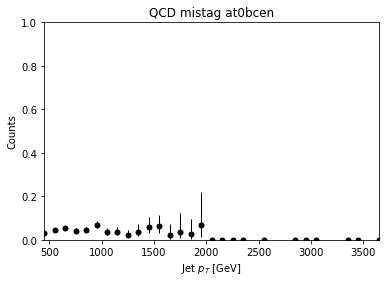

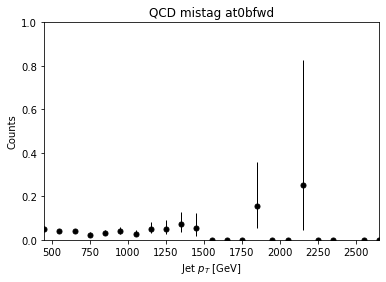

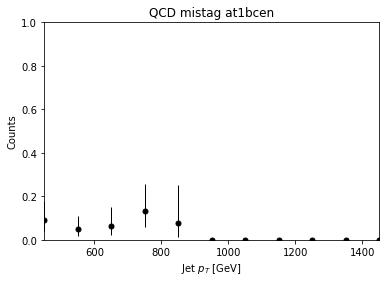

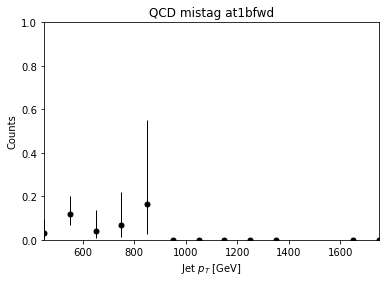

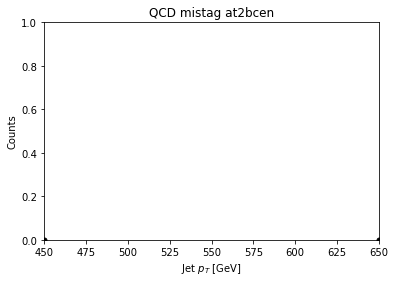

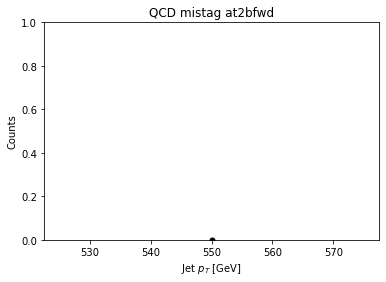

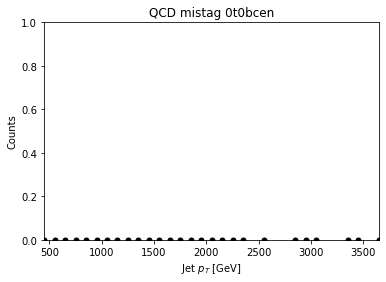

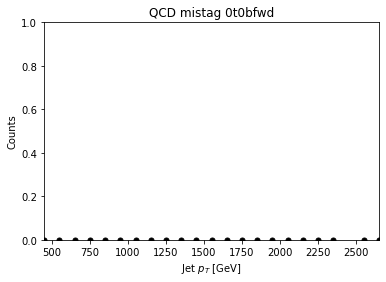

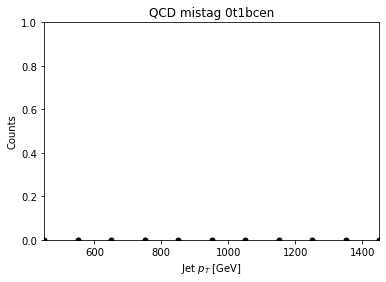

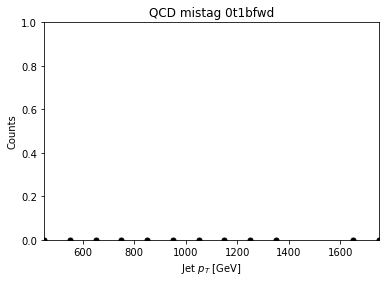

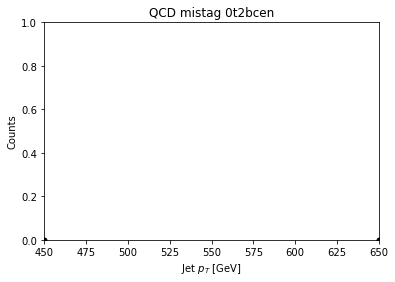

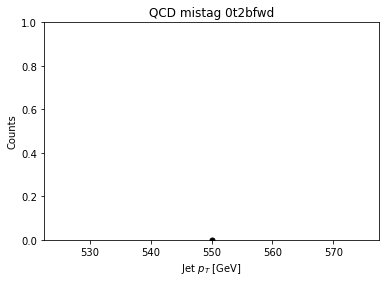

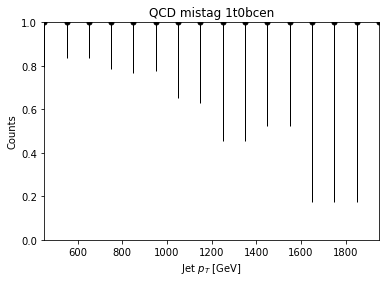

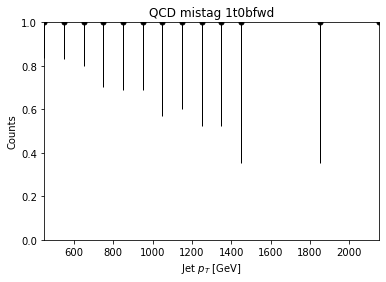

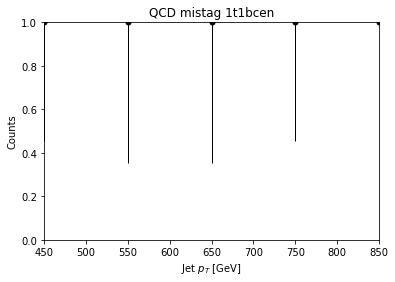

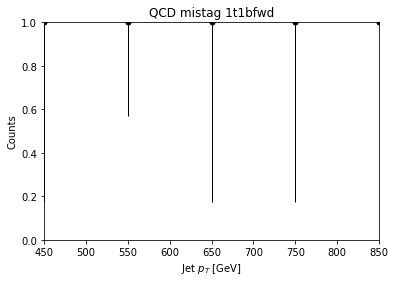

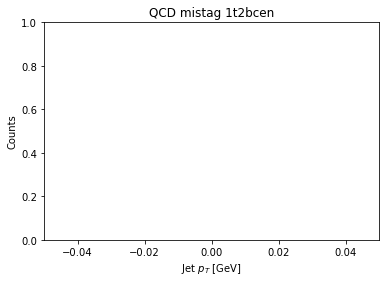

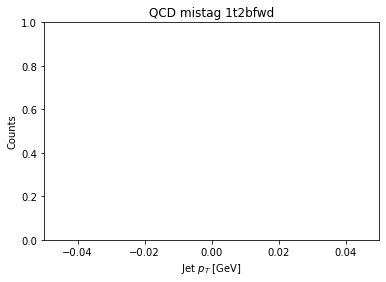

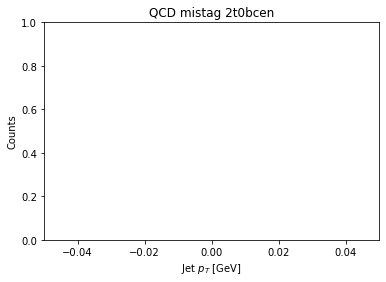

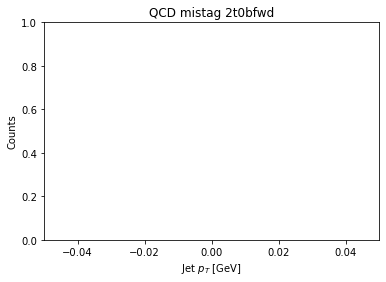

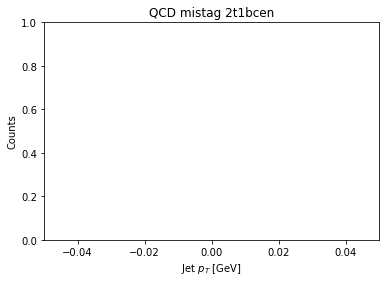

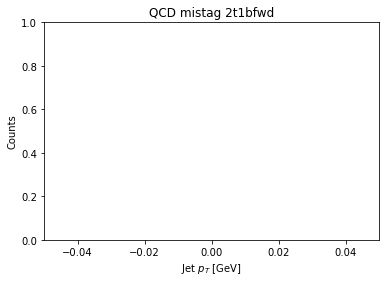

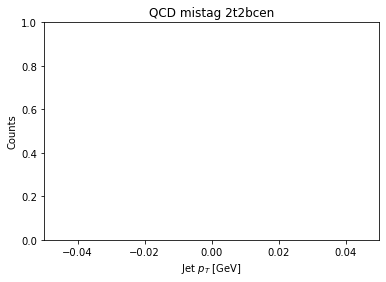

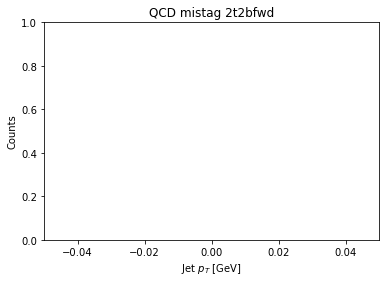

In [18]:
""" ---------------- CREATES MISTAG PLOTS ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #

SaveDirectory = maindirectory + '/MistagPlots/'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times

print(SaveDirectory)
for iset in filesets:
    for icat in list_of_cats:
        print(iset)
        print(icat)
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'png'
        print(outputs_unweighted[iset]['numerator'])
        Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat', icat).integrate('dataset', iset)
        Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat', icat).integrate('dataset', iset)
        print(Numerator)
        print(Denominator)
        mistag = hist.plotratio(num = Numerator, denom = Denominator,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        plt.title(title)
        plt.ylim(bottom = 0, top = 1.0)
        #plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        #print(filename + ' saved')


In [19]:
""" ---------------- LOOK UP TABLE ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #


runLUTS = True 

luts = {}

if runLUTS : 

    SaveDirectory = maindirectory + '/LookupTables/'
    DoesDirectoryExist(SaveDirectory)



    for iset in filesets:
        print('\t\tfileset: ' + iset + '\n*****************************************************\n')
        for icat in list_of_cats:
            title = iset + ' mistag ' + icat
            filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'

            Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat',icat).integrate('dataset',iset)
            Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat',icat).integrate('dataset',iset)
            
            
            
            N_vals = Numerator.values()[()]
            D_vals = Denominator.values()[()]
            
            mistag_vals = np.where(D_vals > 0, N_vals / D_vals, 0)

            p_vals = [] # Momentum values
            for iden in Numerator.identifiers('jetpt'):
                p_vals.append(iden)
                
                

            print('fileset:  ' + iset)
            print('category: ' + icat)
            print('________________________________________________\n')
            print("N values = \n", N_vals)
            print("D values = \n", D_vals)
            print()
            
            d = {'pT': p_vals, 'M(pT)': mistag_vals}
            
            print("d vals = ", d)
            print()
            df = pd.DataFrame(data=d)
            luts[icat] = df

            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(df)
            print('\n')

            df.to_csv(SaveDirectory+filename) # use later to collect bins and weights for re-scaling
else : 
    iset = 'QCD'
    print('\t\tfileset: ' + iset + '\n*****************************************************\n')
    for icat in list_of_cats:
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'
        luts[icat] = pd.read_csv(filename)

		fileset: QCD
*****************************************************

fileset:  QCD
category: at0bcen
________________________________________________

N values = 
 [ 0.  0.  0.  0. 23. 36. 36. 21. 18. 20.  8.  7.  3.  3.  4.  4.  1.  1.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
D values = 
 [  0.   0.   0.   0. 698. 808. 656. 497. 397. 293. 217. 188. 127.  79.
  67.  64.  45.  27.  35.  15.  16.   6.   5.  10.   0.   6.   0.   0.
   1.   2.   1.   0.   0.   1.   1.   0.   1.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]

d vals =  {'pT': [<Interval ([0, 100)) instance at 0x7fb01c0c4090>, <Interval ([100, 200)) instance at 0x7fb01c0c40d0>, <Interval ([200, 300)) instance at 0x7fb01c0c4190>, <Interval ([300, 400)) instance at 0x7fb01c0c41d0>, <Interval ([400, 500)) instance at 0x7fb01c0c4250>, <Interval ([500, 600)) instance at 0x7fb01c0c4290>, <Interval ([600, 700)) instance at

fileset:  QCD
category: 1t1bfwd
________________________________________________

N values = 
 [0. 0. 0. 0. 1. 5. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
D values = 
 [0. 0. 0. 0. 1. 5. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

d vals =  {'pT': [<Interval ([0, 100)) instance at 0x7fb01c0c4090>, <Interval ([100, 200)) instance at 0x7fb01c0c40d0>, <Interval ([200, 300)) instance at 0x7fb01c0c4190>, <Interval ([300, 400)) instance at 0x7fb01c0c41d0>, <Interval ([400, 500)) instance at 0x7fb01c0c4250>, <Interval ([500, 600)) instance at 0x7fb01c0c4290>, <Interval ([600, 700)) instance at 0x7fb01c0c42d0>, <Interval ([700, 800)) instance at 0x7fb01c0c4310>, <Interval ([800, 900)) instance at 0x7fb01c0c4210>, <Interval ([900, 1000)) instance at 0x7fb01c0c4350>, <Interval ([1000, 1100)) instance at 0x7fb01c0

In [20]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 106574.39863664127


In [21]:
tstart = time.time()

fileset = {
    'QCD':qcdfiles
}

outputs_weighted = {}

output_weighted = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTbarResProcessor(UseLookUpTables=True, lu=luts),
                                  executor=processor.dask_executor,
                                  #executor=processor.iterative_executor,
                                  #executor=processor.futures_executor,
                                  executor_args={
                                      'client': client, 
                                      'nano':False, 
                                      'flatten':True, 
                                      'skipbadfiles':False,
                                      'workers': 2},
                                  chunksize=100000, maxchunks=100
                                 )

elapsed = time.time() - tstart
outputs_weighted['QCD'] = output_weighted
print(output_weighted)
print(elapsed)
util.save(output_weighted, 'TTbarResCoffea_full_weighted_QCD_output_100000chunksize_100chunks.coffea')

['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']
{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fb01c0b2550>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fb01c183b90>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fb01c0aab10>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fb00c4fb4d0>, 'probept': <Hist (dataset,anacat,jetpt) instance at 0x7fb00c4fb650>, 'probep': <Hist (dataset,anacat,jetp) instance at 0x7fb01c198f10>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fb01c198990>, 'jety': <Hist (dataset,anacat,jety) instance at 0x7fb01c0ef110>, 'jetdy': <Hist (dataset,anacat,jetdy) instance at 0x7fb00c3cb2d0>, 'subjetmass': <Hist (dataset,anacat,subjetmass) i

In [22]:
for name,output in outputs_weighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted QCD--------
          all events :      9742086
         one FatJets :       386361
         two FatJets :       374671
              jet id :       374668
             jet kin :       232104
two FatJets and jet kin :       181875
     >= one oneTTbar :       181875
          dPhi > 2.1 :        90688
                sumw :            0
               sumw2 :            0
             At0bcen :          168
             At0bfwd :          151
             At1bcen :           10
             At1bfwd :            9
             At2bcen :            0
             At2bfwd :            0
             at0bcen :         4293
             at0bfwd :         3801
             at1bcen :          163
             at1bfwd :          138
             at2bcen :            2
             at2bfwd :            2
             0t0bcen :        42566
             0t0bfwd :        38670
             0t1bcen :         1082
             0t1bfwd :          943
             0t2bcen :         